#### LIBRARIES

In [0]:
#run this to mount google drive to colab

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
# install OpenCV package
#!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

In [0]:
import numpy as np
import pandas as pd
import time
import os

import cv2
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patheffects as PathEffects
import seaborn as sns
from PIL import Image
import glob

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten,BatchNormalization, Activation, GlobalMaxPooling2D, Input
from tensorflow.keras.layers import Dropout,AveragePooling2D
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping




#### CLEAN DATA METHODS

In [0]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#To crop face in an image - extract facial features
def crop_face(clahe_image, face,size):
    #print(type(face))
    for (x, y, w, h) in face:
        #print("in for loop")
        faceslice = clahe_image[y:y+h, x:x+w]
        faceslice = cv2.resize(faceslice, size)
    #facedict["face%s" %(len(facedict)+1)] = faceslice
    return faceslice

#### GRAB YALE DATA

In [0]:
#sharable link to yale data (training dataset): https://drive.google.com/drive/folders/1FA8KaNJ8lTdD8QIfY4zQ1KBl-LMP_Q5W?usp=sharing
#sharable link to face detection xml file: https://drive.google.com/file/d/1oH1TlOJSVs2tl9NjrWNSTMM5_l2YQXqJ/view?usp=sharing

##GRABBING AND DUPLICATING DATA TO INCREASE DATASET SIZE

direct_path = "/content/drive/My Drive/DS8013 - Deep Learning/yaleFaceDataset2/subject"

size = (100, 100)


expr_to_grab = ['happy','sad','surprised']
def build_dataset_type2():
    org_dataset = []
    pic_dataset = []
    expression_label = []
    subject_num = []
    for i in range(1, 16):
      if i != 200: # and i != 4 and i != 11:
          filelist = glob.glob(direct_path+str(i).zfill(2)+"*")

          for fname in filelist:
              subject_num.append(i)
              #print(fname)
              expression = fname.split("_")[1]

              if expression in expr_to_grab:
                #print(expression)
                image = cv2.imread(fname)
                face_cascade = cv2.CascadeClassifier('/content/drive/My Drive/DS8013 - Deep Learning/haarcascade_frontalface_default.xml')
                # Convert into grayscale
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                # Detect faces
                faces = face_cascade.detectMultiScale(gray, 1.1, 4)
                img = crop_face(gray,faces,size)
                pic_dataset.append(img)
                #image = image.resize(size, Image.ANTIALIAS)
                #img = np.array(image)
                img = img.astype('float32')
                img /= 255.0
                # calculate global mean
                mean_global = np.mean(img, axis=0)
                #std_global = img.std()
                # global centering of pixels
                img = img - mean_global
                
                #img /= std_global
                # normalize to the range 0-1
                #img /= 255.0
                img = img.reshape(img.shape[0],img.shape[1],1)
                #img = img.reshape(img.shape[0]*img.shape[1])
                #print(type(img))
                org_dataset.append(img)
                expression_label.append(expression)

    org_dataset = np.array(org_dataset)
    
    return org_dataset,expression_label,pic_dataset,subject_num

org_dataset1,expression_label1,pic_dataset1,subject_num1 = build_dataset_type2()
org_dataset2,expression_label2,pic_dataset2,subject_num2 = build_dataset_type2()
org_dataset3,expression_label3,pic_dataset3,subject_num3 = build_dataset_type2()
org_dataset4,expression_label4,pic_dataset4,subject_num4 = build_dataset_type2()
org_dataset5,expression_label5,pic_dataset5,subject_num5 = build_dataset_type2()
#num_components = len(org_dataset)

org_dataset = np.concatenate((org_dataset1, org_dataset2,org_dataset3,org_dataset4,org_dataset5), axis=0)
expression_label = expression_label1 + expression_label2 + expression_label3 + expression_label4 + expression_label5
print(org_dataset.shape)

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(expression_label)

# binary encode
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded_reshape = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded_reshape)

print(integer_encoded)
#print(onehot_encoded)


dict_emotion_count = {}

for item in expression_label:
    if item in dict_emotion_count: 
        dict_emotion_count[item] += 1 
    else: 
        dict_emotion_count[item] = 1

(225, 100, 100, 1)
[2 0 1 2 0 1 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 0 2 1 0
 1 2 0 2 1 0 2 1 2 0 1 2 0 1 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 1 0 2 0 1
 2 0 1 2 0 2 1 0 1 2 0 2 1 0 2 1 2 0 1 2 0 1 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2
 0 1 2 1 0 2 0 1 2 0 1 2 0 2 1 0 1 2 0 2 1 0 2 1 2 0 1 2 0 1 0 1 2 0 1 2 0
 1 2 0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 0 2 1 0 1 2 0 2 1 0 2 1 2 0 1 2 0
 1 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 0 1 2 1 0 2 0 1 2 0 1 2 0 2 1 0 1 2 0 2 1
 0 2 1]


In [0]:
print(label_encoder.classes_)
print(onehot_encoder.categories_)

['happy' 'sad' 'surprised']
[array([0, 1, 2])]


In [0]:
print(org_dataset.shape)
print('Min: %.3f, Max: %.3f' % (org_dataset[0].min(), org_dataset[0].max()))

(225, 100, 100, 1)
Min: -0.661, Max: 0.609


In [0]:
#GRAB TEST DATA
##sharable link to CK+ data (test dataset): https://drive.google.com/drive/folders/1iG7EUA8NiBAU4g9GLff-UprfwgnN07oE?usp=sharing

file_name_list =['S01_happy_.png','S01_surprise_.png','S011_happy_.png','S011_sad_.png','S011_surprise_.png',
                 'S022_surprise_.png','S026_happy_.png','S032_surprise_.png','S034_surprise_.png','S035_happy_.png','S042_sad_.png',
                 'S044_happy_.png','S050_happy_.png','S050_surprise_.png','S052_surprise_.png','S053_happy_.png','S056_happy_.png',
                 'S058_surprise_.png','S061_happy_.png','S063_happy_.png','S065_surprise_.png','S066_happy_.png','S066_sad_.png',
                 'S069_happy_.png','S071_happy_.png','S079_surprise_.png','S081_sad_.png','S106_sad_.png','S113_sad_.png',
                 'S125_sad_.png','S132_sad_.png','S136_sad_.png','S506_sad_.png','S138_sad_.png','S503_sad_.png','S504_sad_.png','S505_sad_.png',
                 'S037_happy_.png','S052_happy_.png','S055_happy_.png','S060_happy_.png','S072_happy_.png','S086_happy_.png',
                 'S014_sad_.png','S080_sad_.png','S093_sad_.png','S115_sad_.png','S501_sad_.png','S108_sad_.png',
                 'S014_surprise_.png','S026_surprise_.png','S053_surprise_.png','S055_surprise_.png','S060_surprise_.png'] 

test_path = '/content/drive/My Drive/DS8013 - Deep Learning/ck48 datasetTest/'

test_dataset = []
expression_label = []

i = 0
for fname in file_name_list:
  fname = test_path+fname
  #print(fname)
  expression = fname.split("_")[1]
  image = cv2.imread(fname)
  image = cv2.resize(image, size)
  #print(type(image))
  #face_cascade = cv2.CascadeClassifier('/content/drive/My Drive/DS8013 - Deep Learning/haarcascade_frontalface_default.xml')
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  #faces = face_cascade.detectMultiScale(gray, 1.1, 4)
  #img = crop_face(gray,faces,size)
  img = gray.astype('float32')
  img /= 255.0
  mean_global = np.mean(img, axis=0)
  img = img - mean_global
  img = img.reshape(img.shape[0],img.shape[1],1)
  #print(type(img))

  if i > 0:
    np.append(test_dataset,img,axis = 0)
  else:
    test_dataset.append(img)

  expression_label.append(expression)

  #test_dataset = np.array(test_dataset)

  i+= 0

test_label = np.zeros((len(expression_label),3))

i = 0
for express in expression_label:
  if express == 'happy':
    test_label[i][0] = 1
  elif express == 'sad':
    test_label[i][1] = 1
  elif express == 'surprise':
    test_label[i][2] = 1
  i+=1

test_dataset = np.array(test_dataset)


In [0]:
test_dataset.shape

(54, 100, 100, 1)

In [0]:
test_label

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1

#### EXPLORE DATA - NEED TO CHANGE DATSET NAMES HERE

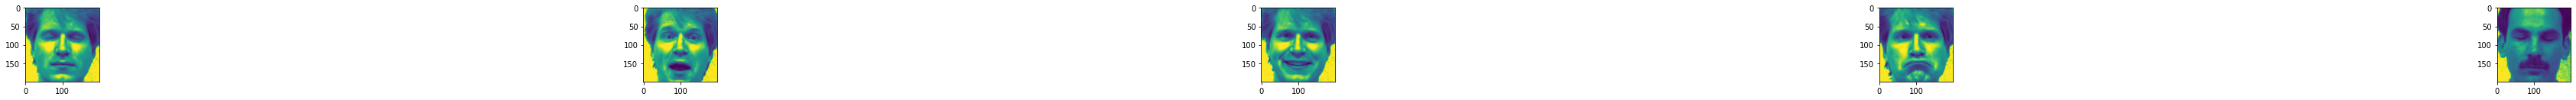

In [0]:

fig=plt.figure(figsize=(70, 70))
columns = 5
rows = 33
for i in range(1,16):
  if subject_num1[i-1] == 1:
    img = pic_dataset1[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    #print(i)
plt.show()

IndexError: ignored

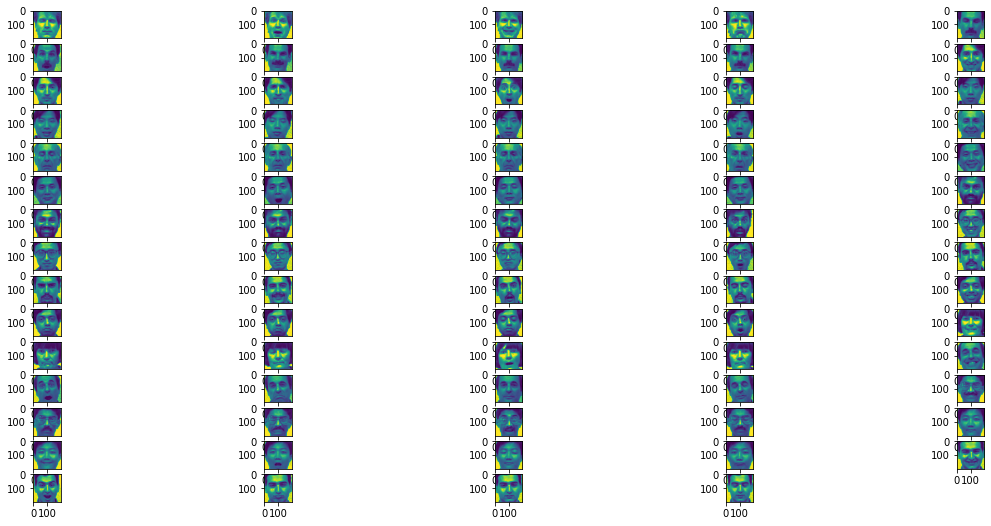

In [0]:
w=10
h=10
fig=plt.figure(figsize=(20, 20))
columns = 5
rows = 33
for i in range(1, columns*rows +1):
    if i<165:
        img = pic_dataset1[i]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    #print(i)
plt.show()

In [0]:
# Utility function to visualize the outputs of PCA and t-SNE

def visulize_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [0]:
org_dataset_reshape = org_dataset.reshape(org_dataset.shape[0],
                                      org_dataset.shape[1]*org_dataset.shape[2]*org_dataset.shape[3])
print(org_dataset_reshape.shape)


test_dataset_reshape = test_dataset.reshape(test_dataset.shape[0],
                                      test_dataset.shape[1]*test_dataset.shape[2]*test_dataset.shape[3])
print(test_dataset_reshape.shape)

(300, 40000)
(15, 40000)


PCA done! Time elapsed: 0.24911713600158691 seconds
Variance explained per principal component: [0.16842034 0.13009383 0.09013285 0.07236841]


(<Figure size 576x576 with 1 Axes>,
 [Text(-2.596634, 0.083411895, '0'),
  Text(-3.3884077, -0.18095103, '1'),
  Text(-0.77103955, 1.3119986, '2'),
  Text(-3.7041903, 0.005436363, '3'),
  Text(-1.6974139, 0.45473585, '4'),
  Text(1.9572681, 1.7795678, '5'),
  Text(3.8732858, 1.1798755, '6'),
  Text(-0.9686086, -2.3373346, '7'),
  Text(-0.61449856, -1.1087192, '8'),
  Text(-0.97018224, 0.53099805, '9'),
  Text(-0.91010094, 1.4642129, '10')])

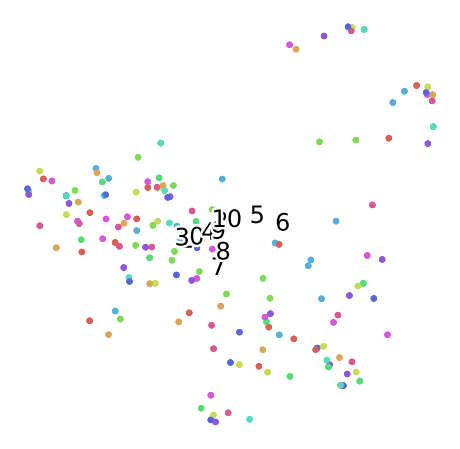

In [0]:
time_start = time.time()

pca = PCA(n_components=4)
pca_result = pca.fit_transform(org_dataset_reshape)

print('PCA done! Time elapsed: %s seconds'%format(time.time()-time_start))

pca_df = pd.DataFrame(columns = ['pca1','pca2','pca3','pca4'])

pca_df['pca1'] = pca_result[:,0]
pca_df['pca2'] = pca_result[:,1]
pca_df['pca3'] = pca_result[:,2]
pca_df['pca4'] = pca_result[:,3]

print ('Variance explained per principal component: %s' % format(pca.explained_variance_ratio_))

top_two_comp = pca_df[['pca1','pca2']] # taking first and second principal component
visulize_scatter(top_two_comp.values,integer_encoded) # Visualizing the PCA output

t-SNE done! Time elapsed: 8.213656902313232 seconds


(<Figure size 576x576 with 1 Axes>,
 [Text(-2.5195472, 6.8213587, '0'),
  Text(-1.7076594, 5.577907, '1'),
  Text(-2.6781955, -4.385032, '2'),
  Text(-1.3561978, 4.7009835, '3'),
  Text(-1.2050724, -9.261711, '4'),
  Text(-1.1827952, -9.571581, '5'),
  Text(-4.287738, 0.64153963, '6'),
  Text(-0.20530586, -5.523384, '7'),
  Text(-2.2685366, -8.402799, '8'),
  Text(-0.027376367, -4.314924, '9'),
  Text(-1.7595075, -5.295936, '10')])

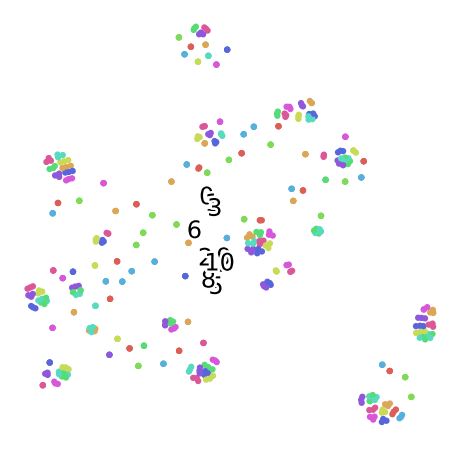

In [0]:
time_start = time.time()

face_tsne = TSNE(random_state=42).fit_transform(org_dataset_reshape)
print('t-SNE done! Time elapsed: %s seconds'%format(time.time()-time_start))
visulize_scatter(face_tsne, integer_encoded)

In [0]:
time_start = time.time()

pca_50 = PCA(n_components=10)

pca_result_50 = pca_50.fit_transform(org_dataset_reshape)
pca_result_50_test = pca_50.fit_transform(test_dataset_reshape)
print ('PCA with 50 components done! Time elapsed: %s seconds'%format(time.time()-time_start))
print ('Cumulative variance explained by 50 principal components: %s'%format(pca_50.explained_variance_ratio_))


time_start = time.time()

face_pca_tsne = TSNE(random_state=42).fit_transform(pca_result_50)
print ('t-SNE done! Time elapsed: %s seconds'%format(time.time()-time_start))

visulize_scatter(face_pca_tsne, integer_encoded)

PCA with 50 components done! Time elapsed: 0.57623291015625 seconds
Cumulative variance explained by 50 principal components: [0.5206568  0.19741228 0.08188805 0.0434732  0.03129316 0.02696382
 0.02395606 0.01952894 0.01580388 0.01440867]
t-SNE done! Time elapsed: 1.496460199356079 seconds


NameError: ignored

#### SPLIT DATA

In [0]:
X_test, X_vald, y_test, y_vald = train_test_split(test_dataset,test_label, test_size=0.1, 
                                                        random_state=42,shuffle = True)

#X_train, X_vald, y_train, y_vald = train_test_split(X_train1,y_train1, test_size=0.1, 
 #                                                       random_state=42,shuffle = True)


#X_train_adjust = np.zeros(X_train.shape)
#X_train_adjust = X_train - np.mean(X_train, axis=0)
#i = 0
#for x in X_train:
 # mean_channel = np.mean(x, axis=0)
  #std_global = img.std()
  #global centering of pixels
  #X_train_adjust[i] = x - mean_channel 
  #i+=1

#print(X_train.shape)
print(X_vald.shape)
print(X_test.shape)
#print(y_train.shape)
print(y_vald.shape)
print(y_test.shape)

(6, 100, 100, 1)
(48, 100, 100, 1)
(6, 3)
(48, 3)


In [0]:
X_vald_concat = np.concatenate((X_vald,X_vald,X_vald),axis = 0)
y_vald_concat = np.concatenate((y_vald,y_vald,y_vald),axis = 0)

print(X_vald_concat.shape)
print(y_vald_concat.shape)


(18, 100, 100, 1)
(18, 3)


In [0]:
#X_train2, X_vald, y_train2, y_vald = train_test_split(X_train,y_train, test_size=0.1, 
 #                                                       random_state=42,shuffle = True)

#IMAGE AUGMENTATION DATASET - NOT USING IT IN FINAL MODEL THOUGH

train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        horizontal_flip=True, vertical_flip = True,
        rotation_range = 20,brightness_range = [1.5,2.0],
        featurewise_std_normalization=True, featurewise_center = True)
# create iterator
it = train_datagen.flow(org_dataset, onehot_encoded)

#print(X_train2.shape)
#print(X_vald.shape)
#print(y_train2.shape)
#print(y_vald.shape)

#### CNN MODEL - NO PCA

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 100, 100, 32)      320       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 100, 100, 32)      9248      
_________________________________________________________________
batch_normalization_17 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 50, 50, 64)        36928     
_________________________________________________________________
batch_normalization_18 (Batc (None, 50, 50, 64)       

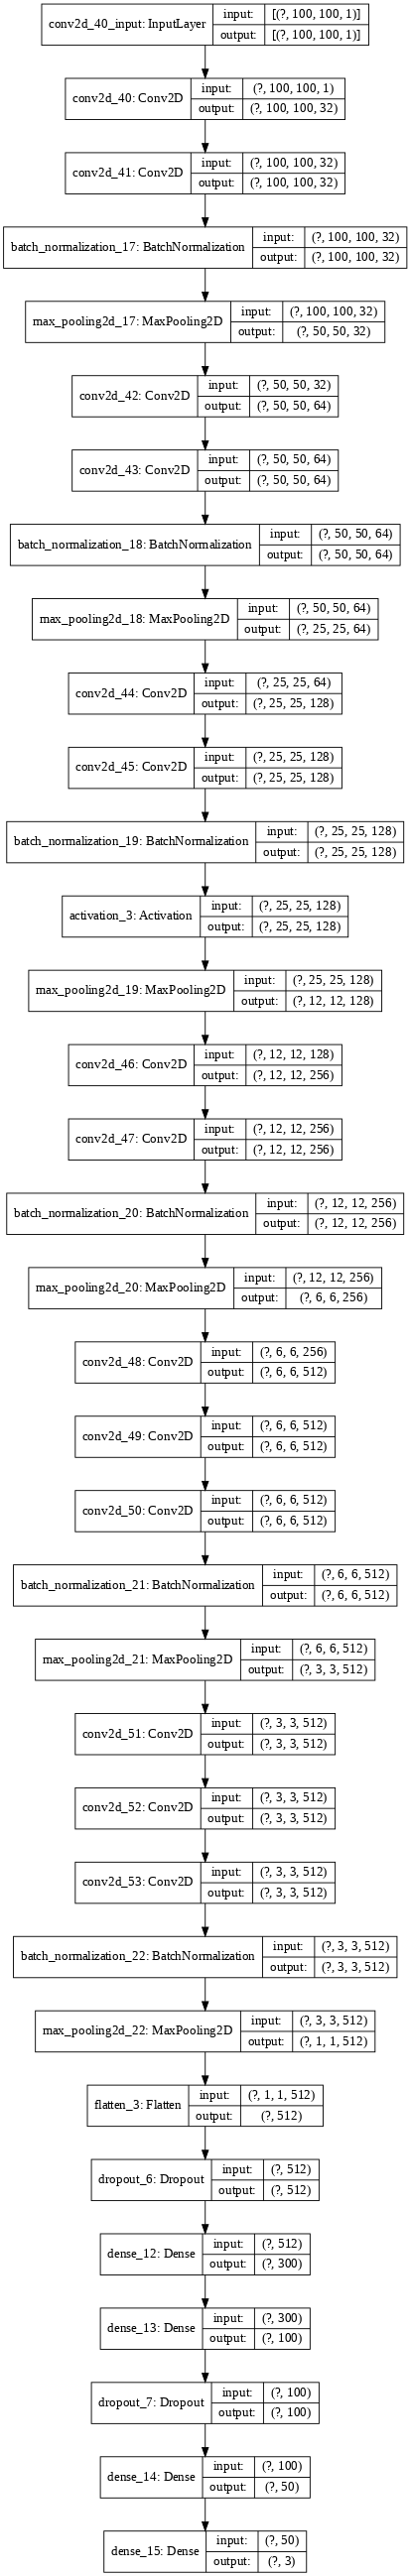

In [0]:
#saved model weights here (file name: weights_best2.hdf5): https://drive.google.com/drive/folders/1IQQ9Mq3Dijn4754xLufe-iPqAA-Arsi9?usp=sharing 


input_shape = (org_dataset.shape[1],org_dataset.shape[2],org_dataset.shape[3])
num_filter = 64
kernel_size = 3
pool_size = 2

model_cnn1 = models.Sequential()

model_cnn1.add(layers.Conv2D(32, (kernel_size, kernel_size), input_shape=input_shape,activation='relu',padding="same"))
#model_cnn1.add(Activation('relu'))
model_cnn1.add(layers.Conv2D(32, (kernel_size, kernel_size), activation='relu',padding="same"))
model_cnn1.add(BatchNormalization())
model_cnn1.add(layers.MaxPooling2D((pool_size, pool_size)))

model_cnn1.add(layers.Conv2D(num_filter, (kernel_size, kernel_size), input_shape=input_shape,activation='relu',padding="same"))
#model_cnn1.add(Activation('relu'))
model_cnn1.add(layers.Conv2D(num_filter, (kernel_size, kernel_size), activation='relu',padding="same"))
model_cnn1.add(BatchNormalization())
model_cnn1.add(layers.MaxPooling2D((pool_size, pool_size)))

#model_cnn1.add(layers.Dropout(0.3))

model_cnn1.add(layers.Conv2D(num_filter*2, (kernel_size, kernel_size),activation='relu',padding="same"))
model_cnn1.add(layers.Conv2D(num_filter*2, (kernel_size, kernel_size), activation='relu',padding="same"))
model_cnn1.add(BatchNormalization())
model_cnn1.add(Activation('relu'))
#model_cnn1.add(layers.Conv2D(num_filter*2, (kernel_size, kernel_size), activation='relu'))
model_cnn1.add(layers.MaxPooling2D((pool_size, pool_size)))

#model_cnn1.add(layers.Conv2D(num_filter*4, (kernel_size, kernel_size),activation='relu',padding="same"))
#model_cnn1.add(layers.Conv2D(num_filter*4, (kernel_size, kernel_size), activation='relu',padding="same"))
#model_cnn1.add(BatchNormalization())
#model_cnn1.add(Activation('relu'))
#model_cnn1.add(layers.Conv2D(num_filter*2, (kernel_size, kernel_size), activation='relu'))
#model_cnn1.add(layers.MaxPooling2D((pool_size, pool_size)))

model_cnn1.add(layers.Conv2D(num_filter*4, (kernel_size, kernel_size),activation='relu',padding="same"))
model_cnn1.add(layers.Conv2D(num_filter*4, (kernel_size, kernel_size),activation='relu',padding="same"))
model_cnn1.add(BatchNormalization())
model_cnn1.add(layers.MaxPooling2D((pool_size, pool_size)))

model_cnn1.add(layers.Conv2D(num_filter*8, (kernel_size, kernel_size),activation='relu',padding="same"))
model_cnn1.add(layers.Conv2D(num_filter*8, (kernel_size, kernel_size),activation='relu',padding="same"))
model_cnn1.add(layers.Conv2D(num_filter*8, (kernel_size, kernel_size),activation='relu',padding="same"))
model_cnn1.add(BatchNormalization())
model_cnn1.add(layers.MaxPooling2D((pool_size, pool_size)))

model_cnn1.add(layers.Conv2D(num_filter*8, (kernel_size, kernel_size),activation='relu',padding="same"))
model_cnn1.add(layers.Conv2D(num_filter*8, (kernel_size, kernel_size),activation='relu',padding="same"))
model_cnn1.add(layers.Conv2D(num_filter*8, (kernel_size, kernel_size),activation='relu',padding="same"))
model_cnn1.add(BatchNormalization())
model_cnn1.add(layers.MaxPooling2D((pool_size, pool_size)))


#model_cnn1.add(layers.Conv2D(num_filter*4, (kernel_size, kernel_size),activation='relu',padding="same"))
#model_cnn1.add(layers.Conv2D(num_filter*4, (kernel_size, kernel_size),activation='relu',padding="same"))
#model_cnn1.add(BatchNormalization())
#model_cnn1.add(layers.MaxPooling2D((pool_size, pool_size)))

#model_cnn1.add(layers.Conv2D(num_filter*4, (kernel_size, kernel_size),activation='relu',padding="same"))
#model_cnn1.add(layers.Conv2D(num_filter*4, (kernel_size, kernel_size),activation='relu',padding="same"))
#model_cnn1.add(BatchNormalization())
#model_cnn1.add(layers.MaxPooling2D((pool_size, pool_size)))

#model.add(GlobalMaxPooling2D())
model_cnn1.add(layers.Flatten())
model_cnn1.add(layers.Dropout(0.3))
model_cnn1.add(layers.Dense(300, activation='relu'))
model_cnn1.add(layers.Dense(100, activation='relu'))
model_cnn1.add(layers.Dropout(0.3))
model_cnn1.add(layers.Dense(50, activation='relu'))
model_cnn1.add(layers.Dense(3, activation='softmax'))

model_cnn1.summary()
# plot model architecture
plot_model(model_cnn1, show_shapes=True,dpi = 65)

In [0]:
sgd = optimizers.SGD(lr=0.01, momentum=0.2)
from tensorflow.keras.callbacks import ModelCheckpoint

def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)
es = EarlyStopping(monitor='val_accuracy', patience=200,restore_best_weights=True,verbose=1)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)


#filepath_to_save = '/content/drive/My Drive/DS8013 - Deep Learning/saved_model/weights_best2.hdf5'
#checkpoint = ModelCheckpoint(filepath_to_save, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#callbacks = [checkpoint]

# Fit the model
#history = model.fit_generator(it, epochs=epochs, steps_per_epoch=batch_size, validation_data=(X_vald,y_vald),callbacks=callbacks)


#Adam(lr=lr_schedule(0))
#model_cnn1.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model_cnn1.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
# Fit the model
history_cnn = model_cnn1.fit(org_dataset, onehot_encoded, epochs=300, batch_size=200, validation_data=(X_vald_concat,y_vald_concat))#,callbacks=callbacks)
#history_cnn = model_cnn1.fit_generator(it, epochs=200, steps_per_epoch=128, validation_data=(X_vald_concat,y_vald_concat),callbacks=callbacks)

Epoch 1/300
2/2 [==============================] - 0s 162ms/step - loss: 2.9802e-09 - accuracy: 1.0000 - val_loss: 1.9872e-04 - val_accuracy: 1.0000
Epoch 2/300
2/2 [==============================] - 0s 42ms/step - loss: 6.2584e-08 - accuracy: 1.0000 - val_loss: 1.9743e-04 - val_accuracy: 1.0000
Epoch 3/300
2/2 [==============================] - 0s 43ms/step - loss: 7.4506e-09 - accuracy: 1.0000 - val_loss: 1.8295e-04 - val_accuracy: 1.0000
Epoch 4/300
2/2 [==============================] - 0s 50ms/step - loss: 5.4836e-08 - accuracy: 1.0000 - val_loss: 2.0015e-04 - val_accuracy: 1.0000
Epoch 5/300
2/2 [==============================] - 0s 43ms/step - loss: 8.9407e-10 - accuracy: 1.0000 - val_loss: 1.9390e-04 - val_accuracy: 1.0000
Epoch 6/300
2/2 [==============================] - 0s 46ms/step - loss: 9.2387e-09 - accuracy: 1.0000 - val_loss: 1.8695e-04 - val_accuracy: 1.0000
Epoch 7/300
2/2 [==============================] - 0s 43ms/step - loss: 8.9407e-10 - accuracy: 1.0000 - val_los

In [0]:
# evaluate model on private test set
score = model_cnn1.evaluate(X_test, y_test, verbose=0)
print ("model %s: %.2f%%" % (model_cnn1.metrics_names[1], score[1]*100))

#filepath_to_save = '/content/drive/My Drive/DS8013 - Deep Learning/saved_model/weights_2_best.hdf5'
# serialize weights to HDF5
#model_cnn1.save_weights(filepath_to_save)

model accuracy: 93.75%


In [0]:
# load weights
filepath_to_save2 = '/content/drive/My Drive/DS8013 - Deep Learning/saved_model/weights_best2.hdf5'

#model_cnn2 = model_cnn1
model_cnn1.load_weights(filepath_to_save2)
model_cnn1.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

print("Created model and loaded weights from file")

# evaluate model on private test set
score = model_cnn1.evaluate(X_test, y_test, verbose=0)
print ("model %s: %.2f%%" % (model_cnn1.metrics_names[1], score[1]*100))

Created model and loaded weights from file
model accuracy: 93.75%


In [0]:
y_pred = model_cnn1.predict_classes(X_test)
y_test_encode = onehot_encoder.inverse_transform(y_test)
#y_pred_encode = onehot_encoder.inverse_transform(y_pred)
#a = np.array([y_pred])[np.newaxis]
print(y_pred)
print(y_test_encode.ravel())

[2 2 1 1 2 2 1 0 1 2 0 0 1 1 2 0 0 0 1 1 2 0 0 1 1 2 0 1 1 2 1 0 0 0 1 0 1
 1 1 0 2 2 1 0 2 1 2 0]
[2 2 1 1 2 2 1 0 1 2 0 0 1 1 2 0 0 0 1 1 2 0 0 1 1 1 0 1 1 2 0 0 0 0 1 0 1
 1 1 0 2 2 2 0 2 1 2 0]


In [0]:
y_true = label_encoder.inverse_transform(y_test_encode.ravel())
y_pred = label_encoder.inverse_transform(y_pred)
y_pred

array(['surprised', 'surprised', 'sad', 'sad', 'surprised', 'surprised',
       'sad', 'happy', 'sad', 'surprised', 'happy', 'happy', 'sad', 'sad',
       'surprised', 'happy', 'happy', 'happy', 'sad', 'sad', 'surprised',
       'happy', 'happy', 'sad', 'sad', 'surprised', 'happy', 'sad', 'sad',
       'surprised', 'sad', 'happy', 'happy', 'happy', 'sad', 'happy',
       'sad', 'sad', 'sad', 'happy', 'surprised', 'surprised', 'sad',
       'happy', 'surprised', 'sad', 'surprised', 'happy'], dtype='<U9')

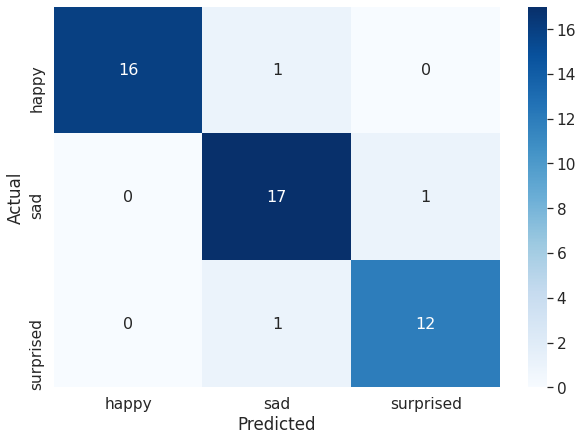

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix

data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.axes_style("whitegrid")
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size

In [0]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(y_true, y_pred, average=None)

(array([1.        , 0.89473684, 0.92307692]),
 array([0.94117647, 0.94444444, 0.92307692]),
 array([0.96969697, 0.91891892, 0.92307692]),
 array([17, 18, 13]))